In [1]:
from math import sqrt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

def round_to_nearest(x, base):
    return base * np.round(x/base)

checker_size = 24 #mm
savefig_kwargs = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

def read_measurements(variant, stroketype):
    path = f"tip_measurements/{variant}/{stroketype}_*.csv"
    f = glob.glob(path)[-1]
    data = pd.read_csv(f, names=["x", "y", "z"]) * 1000
    data["y"] -= checker_size
    data[["x0", "y0"]] = round_to_nearest(data[["x", "y"]], checker_size).astype(int)
    data["z0"] = 0
    data["ex"] = data["x"] - data["x0"]
    data["ey"] = data["y"] - data["y0"]
    data["ez"] = data["z"] - data["z0"]
    data["variant"] = variant
    data["stroketype"] = stroketype
    # data = data.assign(variant=variant, stroketype=stroketype)
    return data

def mean_error(data: pd.DataFrame):
    return np.sqrt(data["ex"]**2 + data["ey"]**2 + data["ez"]**2).mean()

def centroid_error(data: pd.DataFrame):
    return sqrt(data["ex"].mean()**2 + data["ey"].mean()**2 + data["ez"].mean()**2)

def mean_centroid_error(data: pd.DataFrame):
    return data.groupby(["x0", "y0"]).apply(centroid_error).mean()

def mean_var(data: pd.DataFrame):
    return data.groupby(["x0", "y0"])[["ex", "ey", "ez"]].var().mean()

def dispersion(data: pd.DataFrame):
    centroid = data[["ex", "ey", "ez"]].mean()
    dist = data[["ex", "ey", "ez"]] - centroid
    return np.sqrt(dist["ex"]**2 + dist["ey"]**2 + dist["ez"]**2).mean()

def mean_dispersion(data: pd.DataFrame):
    return data.groupby(["x0", "y0"]).apply(dispersion).mean()

def zoomout_plot(data):
    fig = plt.figure()
    ax: Axes = sns.scatterplot(data=data, x="x", y="y")
    ax.set_aspect("equal")
    x0vals = [0, 96, 192]
    y0vals = [0, 120, 240]
    ax.set(xlabel="x (mm)", ylabel="y (mm)", title=" ", xticks=x0vals, yticks=y0vals)
    for x in x0vals:
        ax.axvline(x, color="grey", linestyle="--", linewidth=0.5)
    for y in y0vals:
        ax.axhline(y, color="grey", linestyle="--", linewidth=0.5)

    ax.text(192-10, 240-10, f"Mean error: {mean_error(data):0.2f}mm", color="black", ha="right", va="top",
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey')
    )
    ax.figure.set_figheight(5)
    plt.tight_layout()

def zoomin_plot(data, show_colorbar=True, limits=5):
    g = sns.FacetGrid(data=data, col="x0", row="y0", margin_titles=True, despine=False, sharex=True, sharey=True, aspect=1.07, height=2, row_order=[240, 120, 0])
    norm = plt.Normalize(-1.5, 1.5)
    palette = "coolwarm"
    g.map_dataframe(sns.scatterplot, x="ex", y="ey", hue="ez", palette=palette, s=50, hue_norm=norm)
    g.tight_layout()
    g.set_axis_labels("Δx (mm)", "Δy (mm)")
    g.refline(x=0, y=0, linestyle="--", linewidth=0.5)
    ticks = [-limits+1, 0, limits-1]
    g.set(xlim=(-limits, limits), ylim=(-limits, limits), xticks=ticks, yticks=ticks)
    g.set(aspect="equal")
    g.set_titles(col_template="$x_0$ = {col_name} mm", row_template="$y_0$ = {row_name:0} mm")
    if show_colorbar:
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])
        g.figure.colorbar(sm, ax=g.axes, label="Δz (mm)", aspect=30, pad=0.07)
    g.figure.set_figheight(5)

data_proposed_predicted = read_measurements("proposed", "predicted")
data_proposed_smoothed = read_measurements("proposed", "smoothed")
data_nomarkercalib_predicted = read_measurements("nomarkercalib", "predicted")
data_nomarkercalib_smoothed = read_measurements("nomarkercalib", "smoothed")
data_no2steppnp_predicted = read_measurements("no2steppnp", "predicted")
data_no2steppnp_smoothed = read_measurements("no2steppnp", "smoothed")
data_proposed_smoothed.head(2)

data = pd.concat([
    data_proposed_predicted,
    data_proposed_smoothed,
    data_nomarkercalib_predicted,
    data_nomarkercalib_smoothed,
    data_no2steppnp_predicted,
    data_no2steppnp_smoothed,
])

In [2]:
grouped = data_proposed_smoothed.groupby(["x0", "y0"])

def dispersion(data: pd.DataFrame):
    centroid = data[["ex", "ey", "ez"]].mean()
    dist = data[["ex", "ey", "ez"]] - centroid
    return np.sqrt(dist["ex"]**2 + dist["ey"]**2 + dist["ez"]**2).mean()

grouped.apply(dispersion)

x0   y0 
0    0      0.718743
     120    0.392078
     240    0.459603
96   0      0.691006
     120    0.495251
     240    0.440868
192  0      0.551784
     120    0.517550
     240    0.672910
dtype: float64

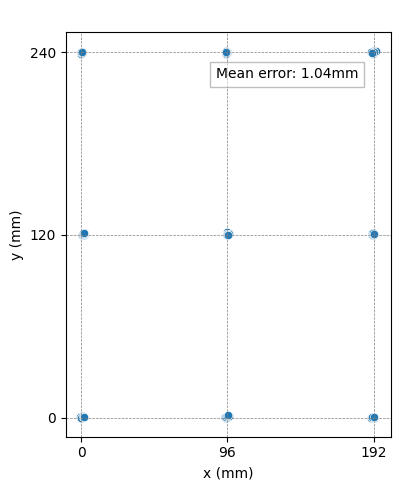

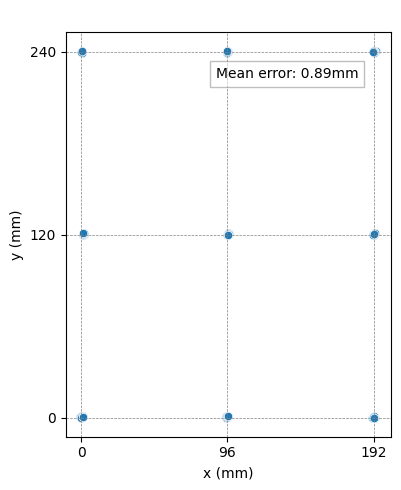

In [2]:
%matplotlib inline

zoomout_plot(data_proposed_predicted)
plt.savefig(f"tip_measurements/proposed/zoomout-predicted.pdf", **savefig_kwargs)
zoomout_plot(data_proposed_smoothed)
plt.savefig(f"tip_measurements/proposed/zoomout-smoothed.pdf", **savefig_kwargs)

c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.p

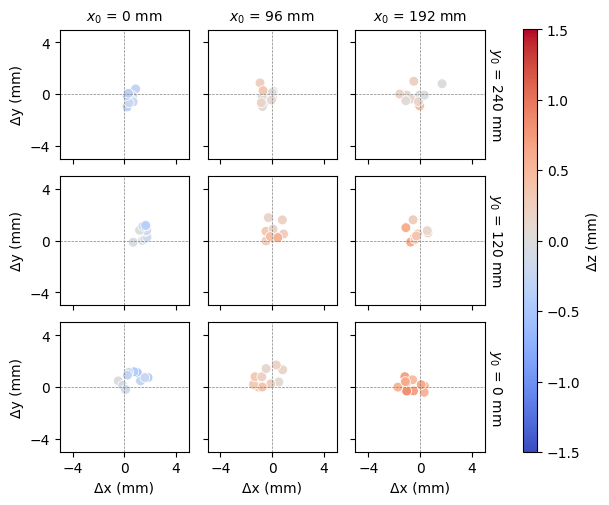

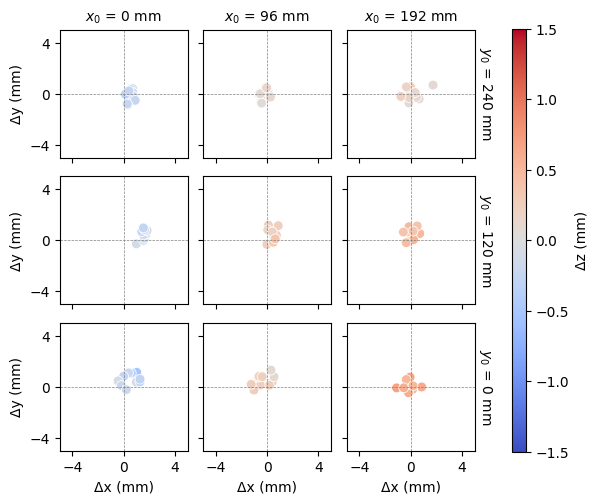

In [3]:
zoomin_plot(data_proposed_predicted)
plt.savefig(f"tip_measurements/proposed/zoomin-predicted.pdf", **savefig_kwargs)
zoomin_plot(data_proposed_smoothed)
plt.savefig(f"tip_measurements/proposed/zoomin-smoothed.pdf", **savefig_kwargs)


'Mean error: 1.482028057093977'

c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


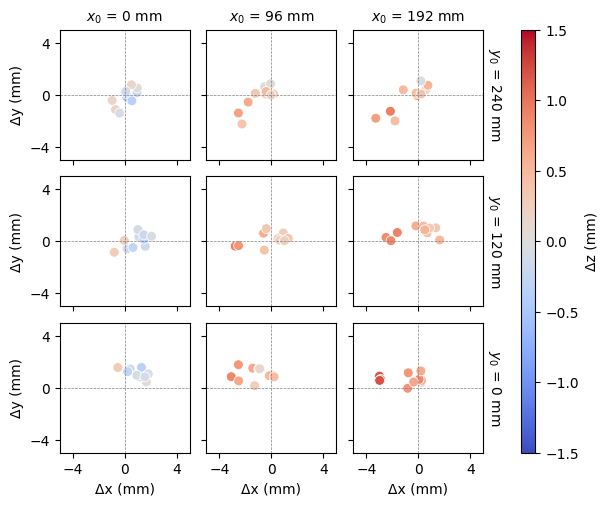

In [31]:
display(f"Mean error: {mean_error(data_nomarkercalib_smoothed)}")
zoomin_plot(data_nomarkercalib_smoothed)
plt.savefig(f"tip_measurements/nomarkercalib/zoomin-smoothed.pdf", **savefig_kwargs)

'Mean error: 2.048285288909192'

c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\James\Files\git\dpoint\python\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


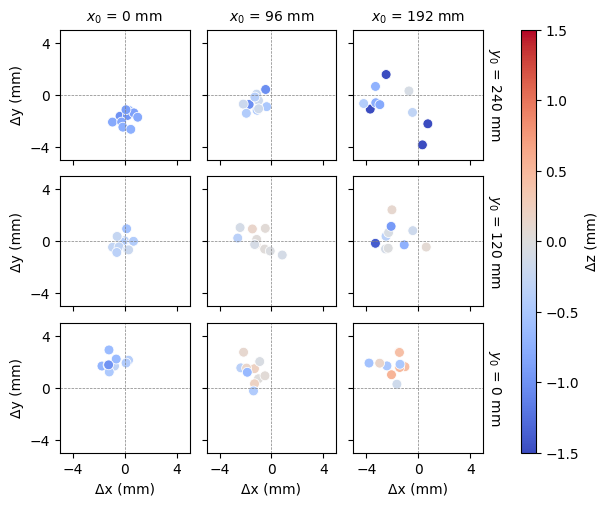

In [34]:
display(f"Mean error: {mean_error(data_no2steppnp_smoothed)}")
zoomin_plot(data_no2steppnp_smoothed)
plt.savefig(f"tip_measurements/no2steppnp/zoomin-smoothed.pdf", **savefig_kwargs)

In [3]:
grouped = data.query("stroketype == 'smoothed'").groupby("variant")
summary = pd.DataFrame({
    "mean_error": grouped.apply(mean_error),
    "mean_dispersion": grouped.apply(mean_dispersion),
    "mean_centroid_error": grouped.apply(mean_centroid_error),
    # "mean_var": grouped.apply(mean_var),
}).round(3).transpose()[["proposed", "no2steppnp", "nomarkercalib"]]
# summary = summary[["proposed", "no2steppnp", "nomarkercalib"]]
display(summary)
var_summary = grouped.apply(mean_var).round(3).transpose()[["proposed", "no2steppnp", "nomarkercalib"]]
display(var_summary)

variant,proposed,no2steppnp,nomarkercalib
mean_error,0.891,2.048,1.482
mean_dispersion,0.549,1.064,1.133
mean_centroid_error,0.674,1.765,1.017


variant,proposed,no2steppnp,nomarkercalib
ex,0.216,0.894,1.336
ey,0.196,0.684,0.422
ez,0.006,0.180,0.052
